# Clustering Geolocation Data Intelligently in Python
We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.

## Prerequisites
- Basic Matplotlib skills for plotting 2-D data clearly.
- Basic understanding of Pandas and how to use it for data manipulation.
- The concepts behind clustering algorithms, although we will go through this throughout the project.

## Project Outline

[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): Clustering Strength / Performance Metric

[**Task 4**](#task4): K-Means Clustering

[**Task 5**](#task5): DBSCAN

[**Task 6**](#task6): HDBSCAN

[**Task 7**](#task7): Addressing Outliers

[**Further Reading**](#further)

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [2]:
df = pd.read_csv('Data/taxi_data.csv')

In [3]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [4]:
df.duplicated(subset=['LON','LAT']).values.any()

True

In [5]:
df.isna().values.any()

True

In [6]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON','LAT'],keep='first',inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [7]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

(823, 2)


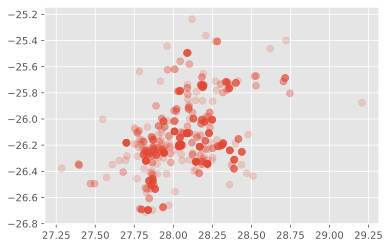

In [8]:
x=np.array(df[['LON','LAT']],dtype='float64')
print(x.shape)
plt.scatter(x[:,0],x[:,1],alpha=0.2,s=50)

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [9]:
m=folium.Map(location=[df.LAT.mean(),df.LON.mean()], zoom_start=9,
             tiles='Stamen Toner')

for _,row in df.iterrows():
    folium.CircleMarker(
    location=[row.LAT,row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+','',row.NAME),
        color='red',
        fil=True,
        fil_colour='red'
    ).add_to(m)

In [10]:
m

<a id='task3'></a>
# Task 3: Clustering Strength / Performance Metric

In [11]:
xblobs,_ = make_blobs(n_samples=1000, centers=10, n_features=2,
                     cluster_std=0.5,random_state=4)

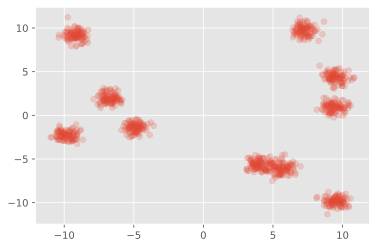

In [12]:
plt.scatter(xblobs[:,0],xblobs[:,1],alpha=0.2)

In [13]:
classpreds = np.load('Data/sample_clusters.npy')

In [14]:
classpreds

array([2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 0,
       2, 0, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2,
       2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2,
       0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0,
       2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2,
       2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 0,
       2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1,
       1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 1,
       0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0,

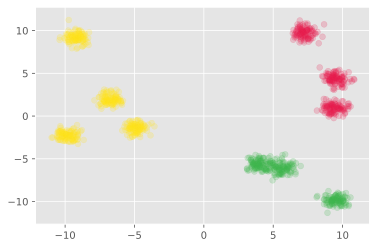

In [15]:
uniqeclust=np.unique(classpreds)
for uni in uniqeclust:
    x = xblobs[classpreds==uni]
    plt.scatter(x[:,0],x[:,1],alpha=0.2,c=cols[uni])

In [16]:
silhouette_score(xblobs,classpreds)

0.6657220862867241

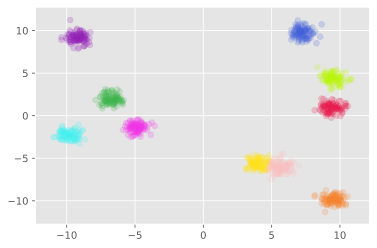

In [17]:
classpreds = np.load('Data/sample_clusters_improved.npy')
uniqeclust=np.unique(classpreds)
for uni in uniqeclust:
    x = xblobs[classpreds==uni]
    plt.scatter(x[:,0],x[:,1],alpha=0.2,c=cols[uni])

In [18]:
silhouette_score(xblobs,classpreds)

0.7473587799908298

<a id='task4'></a>
# Task 4: K-Means Clustering

In [19]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4)

In [20]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(classpreds)

In [21]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [22]:
x = np.array(df[['LON','LAT']],dtype='float64')
k=70
model=KMeans(n_clusters=k,random_state=17).fit(x)
classpreds=model.predict(x)
df[f'kmeans{k}']=classpreds

In [23]:
df.head()

LON       LAT                          NAME  kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank        15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank        15
2  27.83239 -26.53722          Adams Road Taxi Rank         5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank        33
4  28.10144 -26.10567      Alexandra Main Taxi Rank        18

In [24]:
def createmap(df,col):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')
    
    for _, row in df.iterrows():
        if row[col]==-1:
            cluster_colour='#000000'
        else:
            cluster_colour = cols[row[col]]

        folium.CircleMarker(
            location= [row.LAT,row.LON],
            radius=5,
            popup= row[col],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
    return m
m=createmap(df,'kmeans70')  
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(x, classpreds)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6367300948961482


In [25]:
m

In [26]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(x)
    class_predictions = model.predict(x)
    
    curr_silhouette = silhouette_score(x, classpreds)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 98/98 [00:31<00:00,  3.14it/s]

K=2
Silhouette Score: 0.6367300948961482


<a id='task5'></a>
# Task 5: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [27]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5,-1])
new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])
    

In [28]:
model = DBSCAN(eps=0.01, min_samples=5).fit(x)
classpreds=model.labels_
df['dbscan']=classpreds

In [29]:
m = createmap(df,'dbscan')
print(f'Number of clusters found: {len(np.unique(classpreds))}')
print(f'Number of outliers found: {len(classpreds[classpreds==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(x[classpreds!=-1], classpreds[classpreds!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(classpreds)])
print(f'Silhouette outliers as singletons: {silhouette_score(x, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette outliers as singletons: 0.5667489350583482


In [30]:
m

<a id='task6'></a>
# Task 6: HDBSCAN
Hierarchical DBSCAN

In [31]:
model=hdbscan.HDBSCAN(min_cluster_size=5,min_samples=2,cluster_selection_epsilon=0.01)
classpreds=model.fit_predict(x)
df['hdbscan']=classpreds
m=createmap(df,"hdbscan")
m

In [32]:

print(f'Number of clusters found: {len(np.unique(classpreds))-1}')
print(f'Number of outliers found: {len(classpreds[classpreds==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(x[classpreds!=-1], classpreds[classpreds!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(x, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette outliers as singletons: 0.6971082963940812


<a id='task7'></a>
# Task 7: Addressing Outliers


In [33]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [41]:
dfTrain = df[df.hdbscan!=-1]
dfPredict=df[df.hdbscan==-1]

In [42]:
xtrain=np.array(dfTrain[['LON','LAT']],dtype='float64')
ytrain = np.array(dfTrain['hdbscan'])
xpredict=np.array(dfPredict[['LON','LAT']],dtype='float64')

In [43]:
classifier.fit(xtrain,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [44]:
preds=classifier.predict(xpredict)

In [45]:
df['hybrid']=df['hdbscan']
df.loc[df['hdbscan']==-1 , 'hybrid'] =preds

In [46]:
createmap(df,'hybrid')

In [47]:
class_predictions=df.hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(x, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 0, 'ClusterSizes')

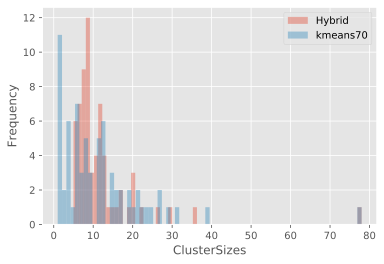

In [50]:
df['hybrid'].value_counts().plot.hist(bins=70,alpha=0.4,label='Hybrid')
df['kmeans70'].value_counts().plot.hist(bins=70,alpha=0.4,label='kmeans70')
plt.legend()
plt.xlabel('ClusterSizes')